# 🏞️ Part 2: Data Exploration
With the basics out of the way, we can now jump into image recognition. Before we begin, we are going to load some useful Python libraries into our environment. You don't need to have a precise understanding of what each library does, but here is a rough summary.

| Library | Description |
| --- | --- |
| `torch` | This is the core `PyTorch` library doing most of the heavy lifting |
| `torchvision` | This is how we will extract the data (if needed), and apply some cleaning to images |
| `random` | This library provides random number generators. This is important if we want to sample images from our dataset | 
| `matplotlib.pyplot` | This is a very popular plotting library |
| `time` | This has functions which allows us to keep track of how long the code takes to run |
| `IPython` | This libraries allows us to access some of the options of these notebooks |
| `numpy` | This is a very popular data manipulation library |
| `helper` | A user-defined module (see the `./helper` subfolder for more details) of useful functions and classes |


In [8]:
# Import relevant libraries
import torch 
import torchvision
from torch import nn 
from torchvision import transforms
from torch.utils import data
import random
import matplotlib.pyplot as plt
import time
from IPython import display
import numpy as np
from helper import helper

random.seed(2021) # We set a seed to ensure our samples will be the same every time we run the code.

## ⚗️ The Data Science Pipleine 
*This section will be repeated in both Part 2 and Part 3*

> What on earth is data science?! -- George Washington (probably not)

Seriously though, nowadays, in such a data-rich world, data science has become the new buzzword, the new cool kid in the block. But what exactly is it? Unfortunately, no one can really pin down a [rigourous definition](https://hdsr.mitpress.mit.edu/pub/jhy4g6eg/release/7) of data science. At the high level:

> Data science is the systematic extraction of novel insight from data.

Good enough! With this definition, most practitioners can somewhat agree on a pipeline or flow. Here are the steps:
1. Identify your problem (What are you trying to do?)
2. Obtain your data (What resource do we have to work with?)
3. Explore your data (What does our data actually look like?)
4. Prepare your data (How do we clean/wrangle our data to make it ingestible?)
5. Model your data (How do we automate the process of drawing out insights?)
6. Evaluate your model (How good are our predictions?)
7. Deploy your model (How can the wider-user base access these insights?)

The 7th step is out-of-scope for this workshop, but we well be exploring the other steps to varying degrees:
* Steps 1-4 will be explored in Part 2.
* Steps 5-6 will be explored in Part 3 and Part 4.


## Step 1: Identify Your Problem 
![cc](../images/confused_cat.jpg)

**Figure:** A day-to-day snapshot of a data scientist at work. ([source](https://s.keepmeme.com/files/en_posts/20200925/confused-cat-looking-at-computer-with-a-lot-of-question-marks-meme-861f3efff59aedea603e35b8c3c059f0.jpg))

### The problem:
* Your boss comes up to you and gives you a stack of unlabelled black & white photos
* You get told you need to identify what item of clothing each photo represents (eg. t-shirt)
* You get a stack of 70,000 labelled picture to give you an idea of the task

*What do you do?!* Sure, you can label them by hand if there are only 100 or 1000 unlabelled images. But what if there are 1,000,000? This manual labelling is not tenable in the long term.

Why use machine learning to automated image recognition?
* **Scalable** -- provided you have a reasonable model and enough computational resources, getting a computer to label images is ***a lot*** easier.
* **Consistent** -- the output of the model is going to be more consistent than any crack team of labelers you can assemble (we are but humans after all).

## Step 2: Obtain Your Data
Alright, you decided you probably won't manually label \* phew \*. What next? Lucky for you, your boss provided you with some initial information:
* There are 70,000 labelled images.
* Each image is an item of clothing.
* Each image is a 28x28 sized image (784 pixels in total).
* Each pixel is black and white, and has a value between 0 and 255 indicating the brightness of the pixel
* There are a total of 10 types of items of clothing.

| Label | Type of Clothing |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat | 
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle Boot |

For example, the following is an image of a boot:

![Boot](../images/boot.png)

In fact, the dataset we are working with is called the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist). In the cell below, we will try to extract the data and split them into the train and test sets (`train_iter` and `test_iter` respectively).

---
## <font color='#F89536'> **Discussion:** </font> 

Why do we need to split the labelled data into train/test sets? (Don't worry, we will go through this in Step 4).

---

⚠️⚠️⚠️ If you clicked ![Binder](https://mybinder.org/badge_logo.svg) to get into the notebook, safely ignore the following. If you have opted to use your own anaconda to run this, we recommend the following parameters:
* `batch_size = 256`
* `n_workers = 4`


In [3]:
# First define the function without running it
def load_data_fashion_mnist(batch_size, n_workers):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=n_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=n_workers))

# Then execute the function here
batch_size = 1024  # Set to 256 on your own device
n_workers = 0      # Set to 4 on your own device
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size, n_workers = n_workers)

#### 🎉🎉🎉 Congratulations! You have just read in your train and test data! 🎉🎉🎉
The format of `train_iter` and `test_iter` is a bit strange, so we have written a function to extract a single example. 

In [9]:
def get_single_sample(data):
    """ Extract a single example from train_iter or test_iter"""
    # First we extract a few random batches (say 3), each of which will have up to your set batch_size (eg. 1024 for mybinder)
    sampled_batches = random.sample(list(data), 3)
    print("The number of mini-batches we have extracted are:", len(sampled_batches))

    # Second we select a single batch to look at, let's say the 3rd one
    batch_no = 2
    ## 0 denotes the predictors
    ## 1 denotes the labels
    predictor = sampled_batches[batch_no][0]
    label = sampled_batches[batch_no][1]
    print("Out of the", len(sampled_batches), "mini-batches, we have selected the", batch_no + 1, "th one.")
    print("The number of images in the mini-batch we selected are:" , len(predictor), " and ", len(label), ". Note these two values should be equal.")

    # Third, we select a single example in the batch, let's say the 100th one
    example_no = 99
    single_predictor = predictor[example_no]
    single_label = label[example_no]
    return (single_predictor, single_label)

In [10]:
single_predictor, single_label = get_single_sample(train_iter)

print("The shape of the predictor", single_predictor.shape)
print("The shape of the label", single_label.shape)

The number of mini-batches we have extracted are: 3
Out of the 3 mini-batches, we have selected the 3 th one.
The number of images in the mini-batch we selected are: 1024  and  1024 . Note these two values should be equal.
The shape of the predictor torch.Size([1, 28, 28])
The shape of the label torch.Size([])


The `shape()` function shows us the **dimensions** of our arrays:
* The predictor has `[1, 28, 28]`: this is a tensor
    * The `1` represents the number of channels (since it's black and white this is only =1. For colour, it =3 since it's RGB).
    * The `28` and `28` represents the dimension of the image (28x28)
* The label has `[]`: this is a scalar

Now let's try to visual it!

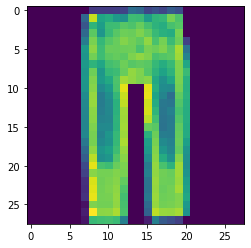

This shows an image of:  1


In [11]:
plt.imshow(single_predictor[0]) # print only the one channel of BW
plt.show()

print("This shows an image of: ", int(single_label))

---
## <font color='#F89536'> **Discussion:** </font> 
Does the image match the label? (See table above).

---

## Step 3: Explore Your Data
Before jumping the gun to model our data, we need to process the data so that it's ready to be modelled. This process is called **data cleaning** and this can be a very involved process, beyond the scope of the workshop. For those interested, [this textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) provides great worked examples of cleaning. Step 4 will touch on some of the additional cleaning/processing steps.

Before even cleaning the data though, we need to ensure we understand what is going in our data (often times we don't collect it ourselves). Here we will focus on looking at the **class distribution**. This is effectively asking ourselves how many of each category is represented in our data. For example, are there more boots than there are t-shirts?

For our model to work, we need the class distribution in the train set to be **similar** to that of the test set. Theoretically, if we just randomly split our labelled data, this will do just fine, but it's always worthwhile to check. Note that you don't need an *exact* match (in reality that will never happen!).

---
## <font color='#F89536'> **Discussion:** </font> 
Why do we prefer the train and test set to have similar class distributions?

---

In [10]:
def data_explore(data_iter):
    class_count = helper.Accumulator(10)
    for i, (X, y) in enumerate(data_iter):
        current_counter = torch.bincount(y)
        class_count.add(current_counter[0], current_counter[1], current_counter[2], current_counter[3], current_counter[4],
                  current_counter[5], current_counter[6], current_counter[7], current_counter[8], current_counter[9]) # This is bad coding practice, don't do this!
    for i in range(10):
        print("Class", i, "has", int(class_count.__getitem__(i)), "images")
        
    return
        
print("Train Data:")
data_explore(train_iter)
print("Test Data")
data_explore(test_iter)

Train Data:
Class 0 has 6000 images
Class 1 has 6000 images
Class 2 has 6000 images
Class 3 has 6000 images
Class 4 has 6000 images
Class 5 has 6000 images
Class 6 has 6000 images
Class 7 has 6000 images
Class 8 has 6000 images
Class 9 has 6000 images
Test Data
Class 0 has 1000 images
Class 1 has 1000 images
Class 2 has 1000 images
Class 3 has 1000 images
Class 4 has 1000 images
Class 5 has 1000 images
Class 6 has 1000 images
Class 7 has 1000 images
Class 8 has 1000 images
Class 9 has 1000 images


![](../images/thanos.jpg)  
([source](https://i.kym-cdn.com/entries/icons/original/000/027/257/perfectly-balanced-as-all-things-should-be.jpg))

In reality, your data won't be this perfect, it's always worth checking and understanding class balances!

## Step 4: Prepare Your Data
This was something we have previously alluded to, but we have 70,000 labelled examples. Perfect! Do we throw them all into the training/fitting process of the model?

The answer is **NO**. 

---
## <font color='#F89536'> **Discussion:** </font> 
Why is that though? Doesn't more data = better model?

---

![yesbutno](../images/yesbutno.jpg)

The reason lies in a concept known as **overfitting**. Remember, our goal is to make sure the model works well on hiterto unseen data (ie. unlabelled data). If we just throw all the data we have into the train process, then we won't have access to an independent dataset to evaluate the model. Later on, we will see how the test data can be used to assess overfitting. For now, just remember that it is vital that we have an (representative) subset of the labelled data set aside for evaluation. For the purposes of this example, 60,000 images will be used to train and 10,000 images will be used to test:
* `Train` -- this is the data we use to fit the model (n=60,000)
* `Validate` -- we will not be using this today to tune hyper-parameters
* `Test` -- this is the data we use to determine the model performance (n=10,000)

**Hyperparameter** = parameters the user (you!) choose beforehand (as opposed to parameters the model learns from the data, such as the weights of a neural network) 

e.g. the batch number, the number of layers in a neural network, the width of each layer etc.

*How do you choose?*  
Normally you would have a bunch of values to choose from (eg. `batch_size = {256, 512, 1024}`). Then using these values, you would train your neural network, and apply the model to your validate set. The hyperparameter which gives the best model performance has the best hyperparameters. The overall problem of choosing hyperparameters is called **hyperparameter tuning** and this approach just described is called **grid search**.

---
## <font color='#F89536'> **Discussion:** </font> 
What's the problem with grid search?

---

---

# *DEPRECATE BELOW*

### ⬇️ Input

The function `load_data_fashion_mnist` takes in two input arguments:
* `batch_size`: The number of examples we use to train before each 'update' of the weight. We will discuss this further in Step 5. For now, all we need to know is there is a general trade off:
    * Small batch size: Less stable training (since our weight update is reliant on very few examples)
    * Large batch size: Tends to be a bit slower and requires a bit more memory.
* and `n_workers`: The number of computer (CPU or GPU) cores engaged in reading the data.

The recommended argument will be different depending on whether you are running this on mybinder or your own machine.

#### For mybinder users (Default)
Due to limited resources, these values seem to provide a stable outcome:
* `batch_size = 1024`
* `n_workers = 0`

#### For those on their own machines
You should have more resources than mybinder, we recommend the following:
* `batch_size = 256`
* `n_workers = 4`

Note if you are using GPU acceleration, you may choose to use more worker nodes. See Appendix for more detail.

### 💉 Types of `import`
*THIS IS TOO VERBOSE*  
You might notices that we are importing libraries in various ways. We need to remind ourselves of the different ways of importing.

1. Importing the entire module  
This makes the entire package available for use to the user. So if we run `import numpy`, we can access resources inside the `numpy` library by prefixing our desired function with the package name: for example `numpy.array()`.

2. Importing and renaming  
Sometimes the package names are really long, so we don't fancy writing it out every time. In that case, we can rename it `import numpy as np` so that when we call it again, the prefix doesn't have to be as long: for example `np.array()`.

3. Importing sub-modules/resources  
If there are resources inside packages that are really useful to us, we can specifically import those. For example `from numpy import array`. In this case, we do not have to prefix it at all: for example `array()`.

4. Importing the entire module without prefix  
There is a way to import all of a package's resources without having to prefix. This is by using the wildcard `*`, `from numpy import *` will make **all** resources available without prefixing. ***NEVER EVER EVER DO THIS.*** The problem with this method is that often packages have very generic names for their functions (eg. `array()`. This might conflict with pre-existing functions and this will end very badly.

---
#### <font color='red'> A Lesson on Data Structures `DataLoader` vs. `DataSet` </font>
PyTorch natively provides two data structures to work with. `DataLoader` and `DataSet`. Here's a bit of comparison:

| `DataSet` | `DataLoader` |
| --- | --- |
| Typical dataset object (like a table) | An iterator object |
| Reads in all the data at once and stores in memory | Reads in data only when the function is called |
| Good for smaller datasets | Good for larger datasets |



Weird, it's not printing out the mini-batch, but rather some weird thing called a DataLoader object. There's actually a really good reason for this! If we are dealing with big datasets, reading the data in as a table would mean we need to store the entire thing in memory (RAM) - this can be up to 10-20GB which can cripple a normal computer! Instead we use the DataLoader object to read in the dataset as we need it (and discarding it otherwise). This might be a bit slower, but far more manageable in terms of memory resources. This means there's a very particular way to extract a single example, which we will attempt to do below:


### ⬆️ Output

For this particular example, we didn't have to explicitly split the data into train and test set, it came pre-split:
* 60,000 images into `train_iter`
* 10,000 images into `test_iter`

If we try to view examples of these images, we encounter something strange.

In [8]:
print(test_iter)

This is weird, we *should* get something like the image of the boot above. Or perhaps even some computerised version of it (like a matrix). Now, there IS a way to do that, but the reason why it doesn't is quite interesting. If you would like to know, read on. Otherwise, skip down a few cells.

<font color='#F89536'> **Discussion:** </font> In the code above, we used `batch_no + 1`. Why is the `+ 1` necessary? What does it add?